In [1]:
""" Created on March 22, 2023 // @author: Sarah Shi """

import numpy as np
import pandas as pd
import scipy

import os
import time
import random
import pickle
import warnings
warnings.simplefilter('ignore', category=(FutureWarning,UserWarning))

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import hdbscan
from hdbscan.flat import (HDBSCAN_flat, approximate_predict_flat, membership_vector_flat, all_points_membership_vectors_flat)

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import scale, normalize, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_recall_fscore_support
from imblearn.over_sampling import RandomOverSampler

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import rc
import matplotlib.cm as mcm
import matplotlib.path as mpath
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
rc('font',**{'family':'Avenir', 'size': 20})
plt.rcParams['pdf.fonttype'] = 42

In [2]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

def save_model(model, optimizer, path):
    check_point = {'params': model.state_dict(),                            
                   'optimizer': optimizer.state_dict()}
    torch.save(check_point, path)

def load_model(model, optimizer=None, path=''):
    check_point = torch.load(path)
    model.load_state_dict(check_point['params'])
    if optimizer is not None:
        optimizer.load_state_dict(check_point['optimizer'])

def getLatent(model, dataset:np):
    #transform real data to latent space using the trained model
    latents=[]
    model.to(device)

    dataset_ = FeatureDataset(dataset)
    loader = DataLoader(dataset_,batch_size=20,shuffle=False)
    
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(loader):
            x = data.to(device)
            z = model.encoded(x)
            latents.append(z.detach().cpu().numpy())
    
    return np.concatenate(latents, axis=0)

def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

class FeatureDataset(Dataset):
    def __init__(self, x):
        if len(x.shape)==2:
            self.x = x
        else:
            self.x = x.reshape(-1, x.shape[-1]) #dataset keeps the right shape for training

    def __len__(self):
        return self.x.shape[0] 
    
    def __getitem__(self, n): 
        return torch.Tensor(self.x[n])

class Tanh_Autoencoder(nn.Module):
    def __init__(self,input_dim = 10, latent_dim = 2, hidden_layer_sizes=(256, 64, 16)):
        super(Tanh_Autoencoder, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.hls = hidden_layer_sizes

        def element(in_channel, out_channel):
            return [
                nn.Linear(in_channel, out_channel),
                nn.LayerNorm(out_channel),
                nn.Tanh(),
            ]

        encoder = element(self.input_dim, self.hls[0])
        for i in range(len(self.hls) - 1):
            encoder += element(self.hls[i], self.hls[i + 1])
        encoder += [nn.Linear(self.hls[-1], latent_dim)]

        decoder = element(latent_dim, self.hls[-1])
        for i in range(len(self.hls) - 1, 0, -1):
            decoder += element(self.hls[i], self.hls[i - 1])
        decoder += [nn.Linear(self.hls[0], self.input_dim)] # nn.Softmax()]

        self.encode = nn.Sequential(*encoder)
        self.decode = nn.Sequential(*decoder)

        self.apply(weights_init)

    def encoded(self, x):
        #encodes data to latent space
        return self.encode(x)

    def decoded(self, x):
        #decodes latent space data to 'real' space
        return self.decode(x)

    def forward(self, x):
        en = self.encoded(x)
        de = self.decoded(en)
        return de

def train(model, optimizer, train_loader, test_loader, n_epoch, criterion):
    
    avg_train_loss = []
    avg_test_loss = []

    for epoch in range(n_epoch):
        # Training
        model.train()
        t = time.time()
        train_loss = []
        for i, data in enumerate(train_loader):
            x = data.to(device)
            x_recon = model(x)
            loss = criterion(x_recon, x)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss.append(loss.detach().item())
        
        # Testing
        model.eval()
        test_loss = []
        for i, test in enumerate(test_loader):
            x = test.to(device)
            x_recon = model(x)
            loss = criterion(x_recon, x)
            test_loss.append(loss.detach().item())
        
        # Logging
        avg_loss = sum(train_loss) / len(train_loss)
        avg_test = sum(test_loss) / len(test_loss)
        avg_train_loss.append(avg_loss)
        avg_test_loss.append(avg_test)
        
        training_time = time.time() - t
        
        print(f'[{epoch+1:03}/{n_epoch:03}] train_loss: {avg_loss:.6f}, test_loss: {avg_test:.6f}, time: {training_time:.2f} s')

    return avg_train_loss, avg_test_loss

def autoencode(df, name, AE_Model, hidden_layer_sizes):

    oxides = ['SiO2', 'TiO2', 'Al2O3', 'FeOt', 'MnO', 'MgO', 'CaO', 'Na2O', 'K2O', 'Cr2O3']

    wt = df[oxides].fillna(0)
    wt = wt.to_numpy()

    #perform z-score normalisation
    array_norm_wt = normalize(wt)

    ss = StandardScaler()
    array_norm = ss.fit_transform(wt)

    #split the dataset into train and test sets
    train_data, test_data = train_test_split(array_norm, test_size=0.1, stratify = df['Mineral'], random_state=42)

    #define datasets to be used with PyTorch - see autoencoder file for details
    feature_dataset = FeatureDataset(train_data)
    test_dataset = FeatureDataset(test_data)   

    #autoencoder params:
    lr = 5e-4
    wd = 0
    batch_size = 256
    epochs = 50
    input_size = feature_dataset.__getitem__(0).size(0)

    #define data loaders
    feature_loader = DataLoader(feature_dataset, batch_size=batch_size,shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)
    np.savez('autoencoder_parametermatrix/' + name + '_features.npz', feature_loader = feature_loader, test_loader = test_loader)

    #define model
    model = AE_Model(input_dim=input_size, hidden_layer_sizes = hidden_layer_sizes).to(device)

    #use ADAM optimizer with mean squared error loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=wd) 
    criterion = nn.MSELoss()

    #train model using pre-defined function
    train_loss, test_loss = train(model, optimizer, feature_loader, test_loader, epochs, criterion)
    np.savez('autoencoder_parametermatrix/' + name + '_tanh_loss.npz', train_loss = train_loss, test_loss = test_loss)

    #transform entire dataset to latent space
    z = getLatent(model, array_norm)

    phase = np.array(['Amphibole', 'Apatite', 'Biotite', 'Clinopyroxene', 'FeTiOxide',
        'Garnet', 'KFeldspar', 'Muscovite', 'Olivine', 'Orthopyroxene',
        'Plagioclase', 'Quartz', 'Rutile', 'Spinel', 'Tourmaline',
        'Zircon'])
    phasez = range(1,len(phase))
    tab = plt.get_cmap('tab20')
    cNorm  = mcolors.Normalize(vmin=0, vmax=len(phase))
    scalarMap = mcm.ScalarMappable(norm=cNorm, cmap=tab)

    # save main model params
    model_path = name + "_tanh_params.pt"
    save_model(model, optimizer, model_path)

    # save all other params
    conc_file = name + "_tanh.npz"
    np.savez('autoencoder_parametermatrix/' + name + "_tanh.npz", batch_size = batch_size, epochs = epochs, input_size = input_size, 
            conc_file = conc_file, z = z)

    return z 

def feature_normalisation(feature, return_params = False, mean_norm = True):
    """
    Function to perform mean normalisation on the dataset passed to it.
    
    Input
    ----------
    feature (numpy array) - features to be normalised
    return_params (boolean, optional) - set True if parameters used for mean normalisation
                            are to be returned for each feature
                            
    Returns
    ----------
    norm (numpy array) - mean normalised features
    params (list of numpy arrays) - only returned if set to True above; list of parameters
                            used for the mean normalisation as derived from the features
                            (ie. mean, min and max).
    """
    
    params = []
    
    norm = np.zeros_like(feature)
    
    if len(feature.shape) == 2:
        for i in range(feature.shape[1]):
            if mean_norm == True:
                temp_mean = feature[:,i].mean()
            elif mean_norm == False:
                temp_mean = 0
            else:
                raise ValueError("Mean_norm must be boolean")
            norm[:,i] = (feature[:,i] - temp_mean) / (feature[:,i].max() - feature[:,i].min())
            params.append(np.asarray([temp_mean,feature[:,i].min(),feature[:,i].max()]))
    
    elif len(feature.shape) == 1:
        if mean_norm == True:
            temp_mean = feature[:].mean()
        elif mean_norm == False:
                temp_mean = 0
        else:
            raise ValueError("Mean_norm must be boolean")
        norm[:] = (feature[:] - temp_mean) / (feature.max() - feature.min())
        params.append(np.asarray([temp_mean,feature[:].min(),feature[:].max()]))
        
    else:
        raise ValueError("Feature array must be either 1D or 2D numpy array.")
        
    
    if return_params == True:
        return norm, params
    else:
        return norm

<ipython-input-3-43974e5a8c12>:67: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  georoc_df = pd.read_csv('Validation_Data/GEOROC_validationdata.csv')


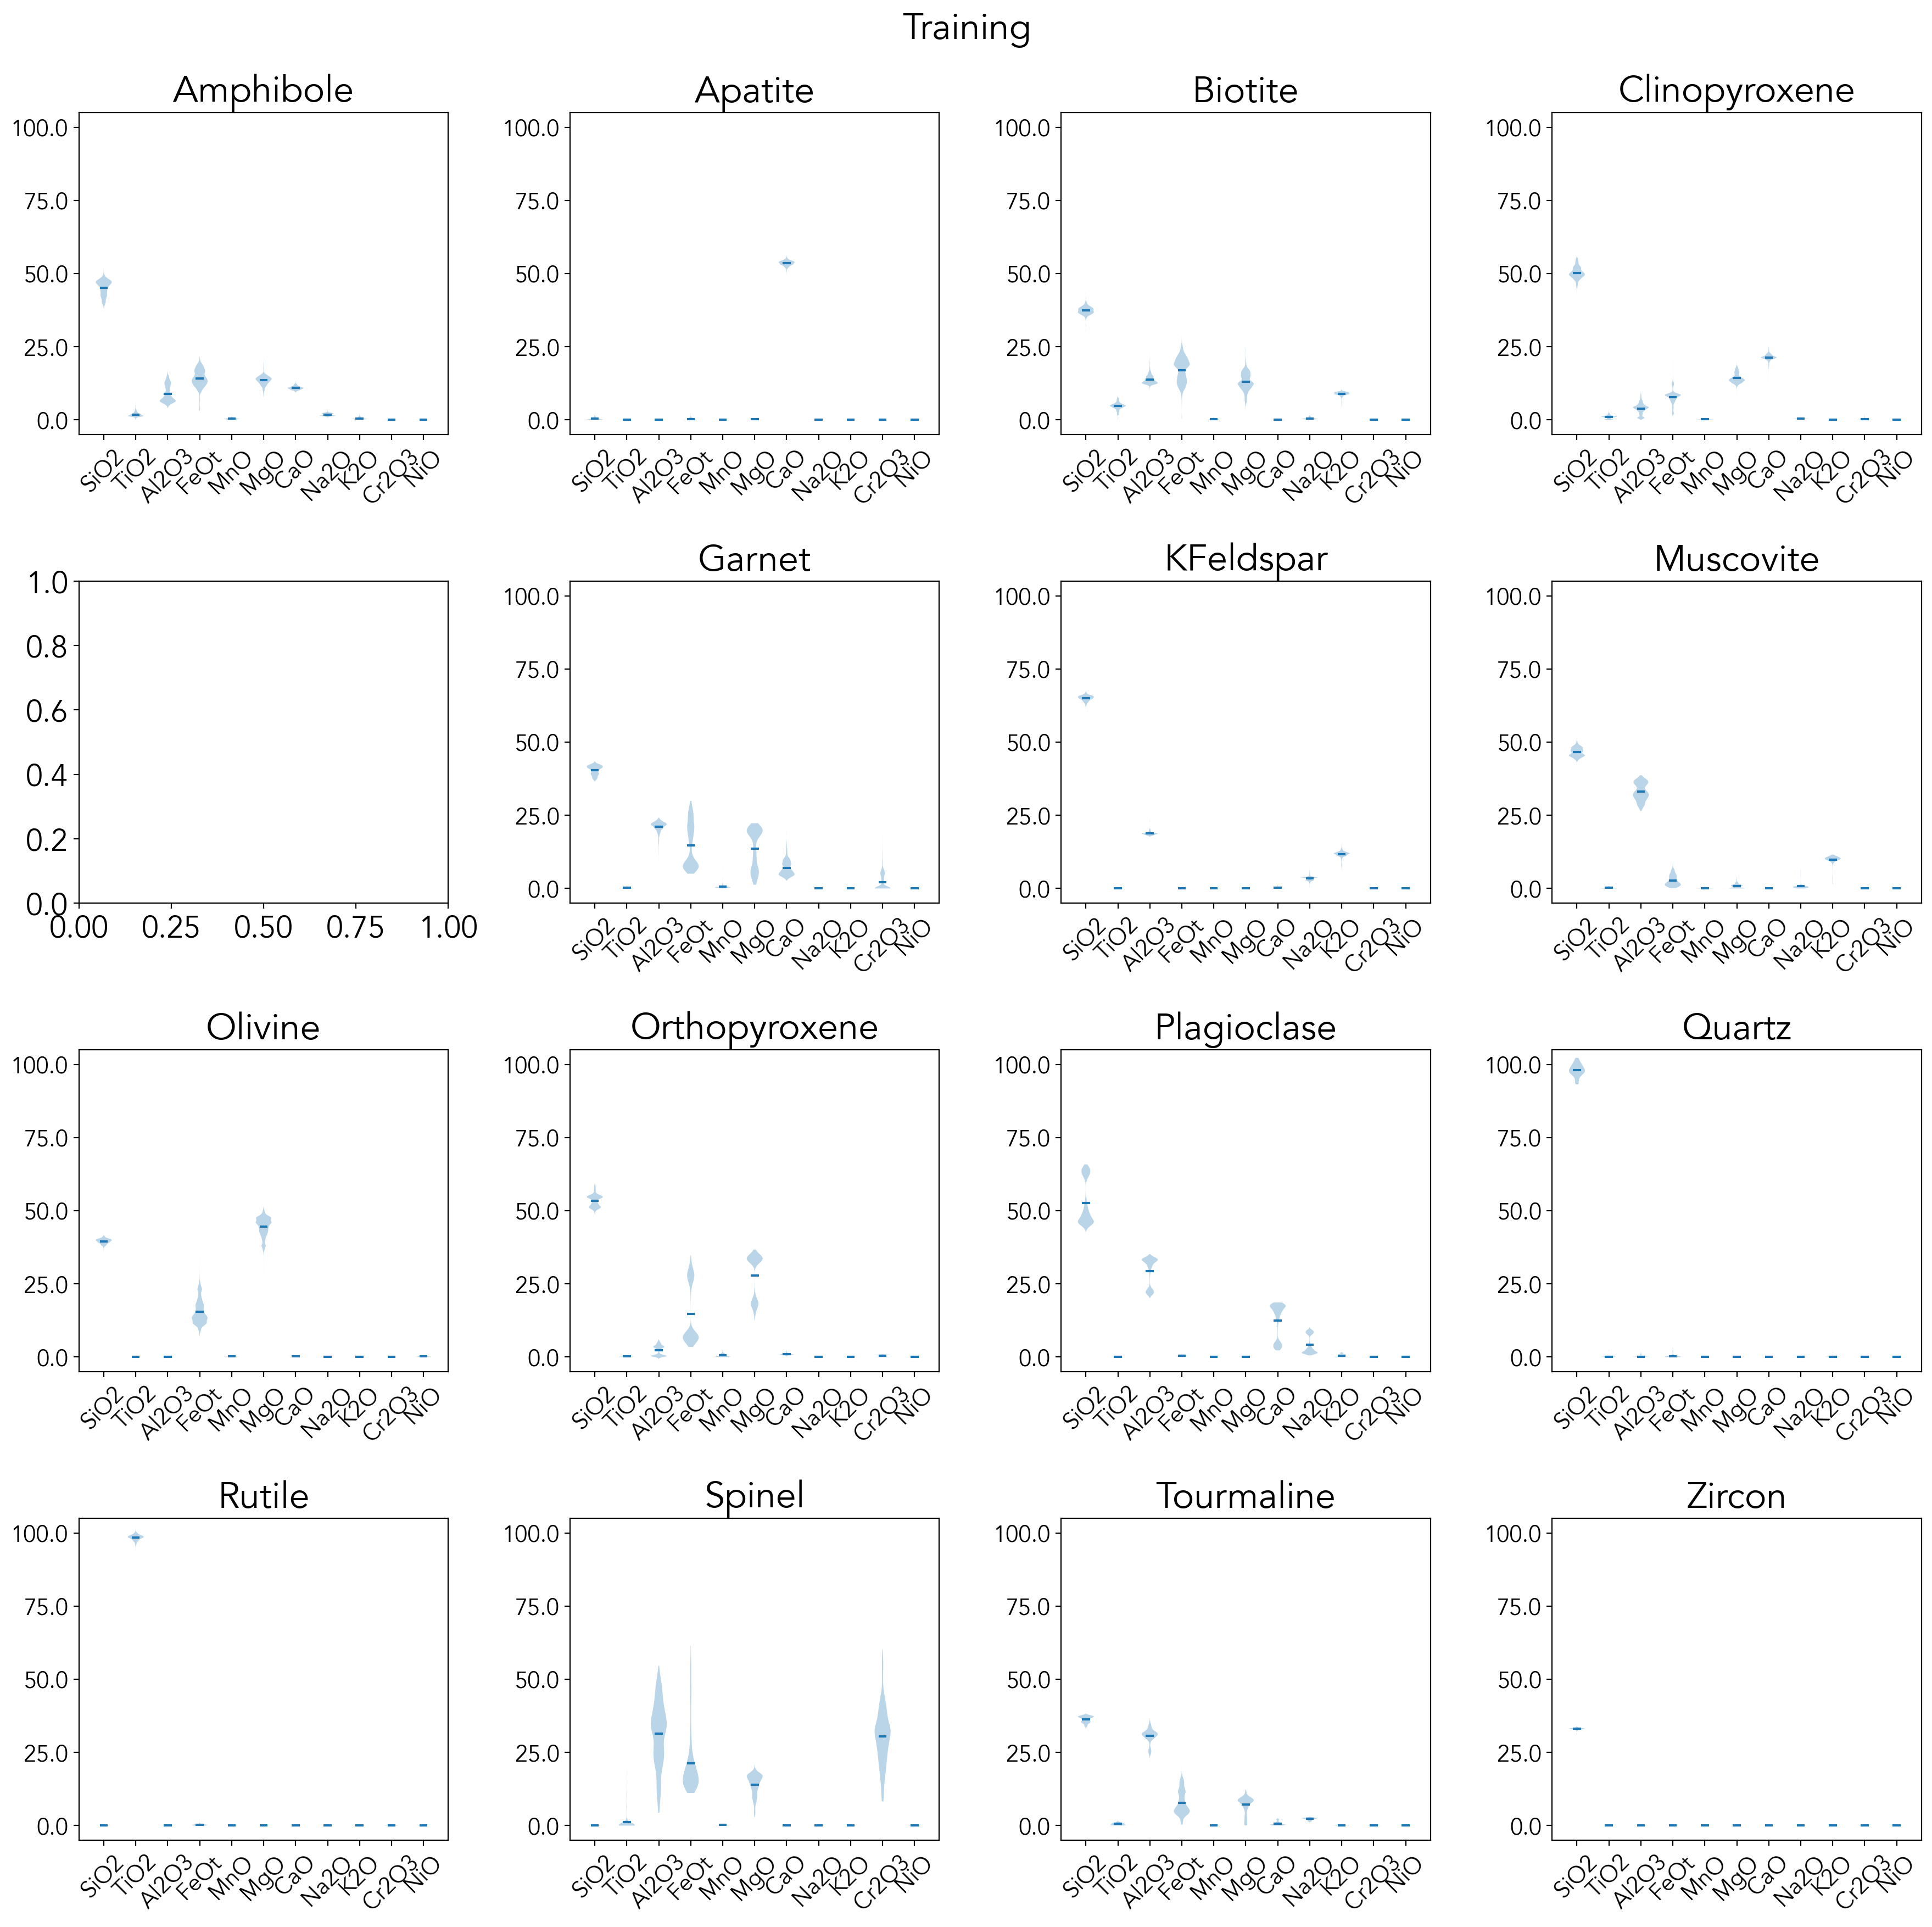

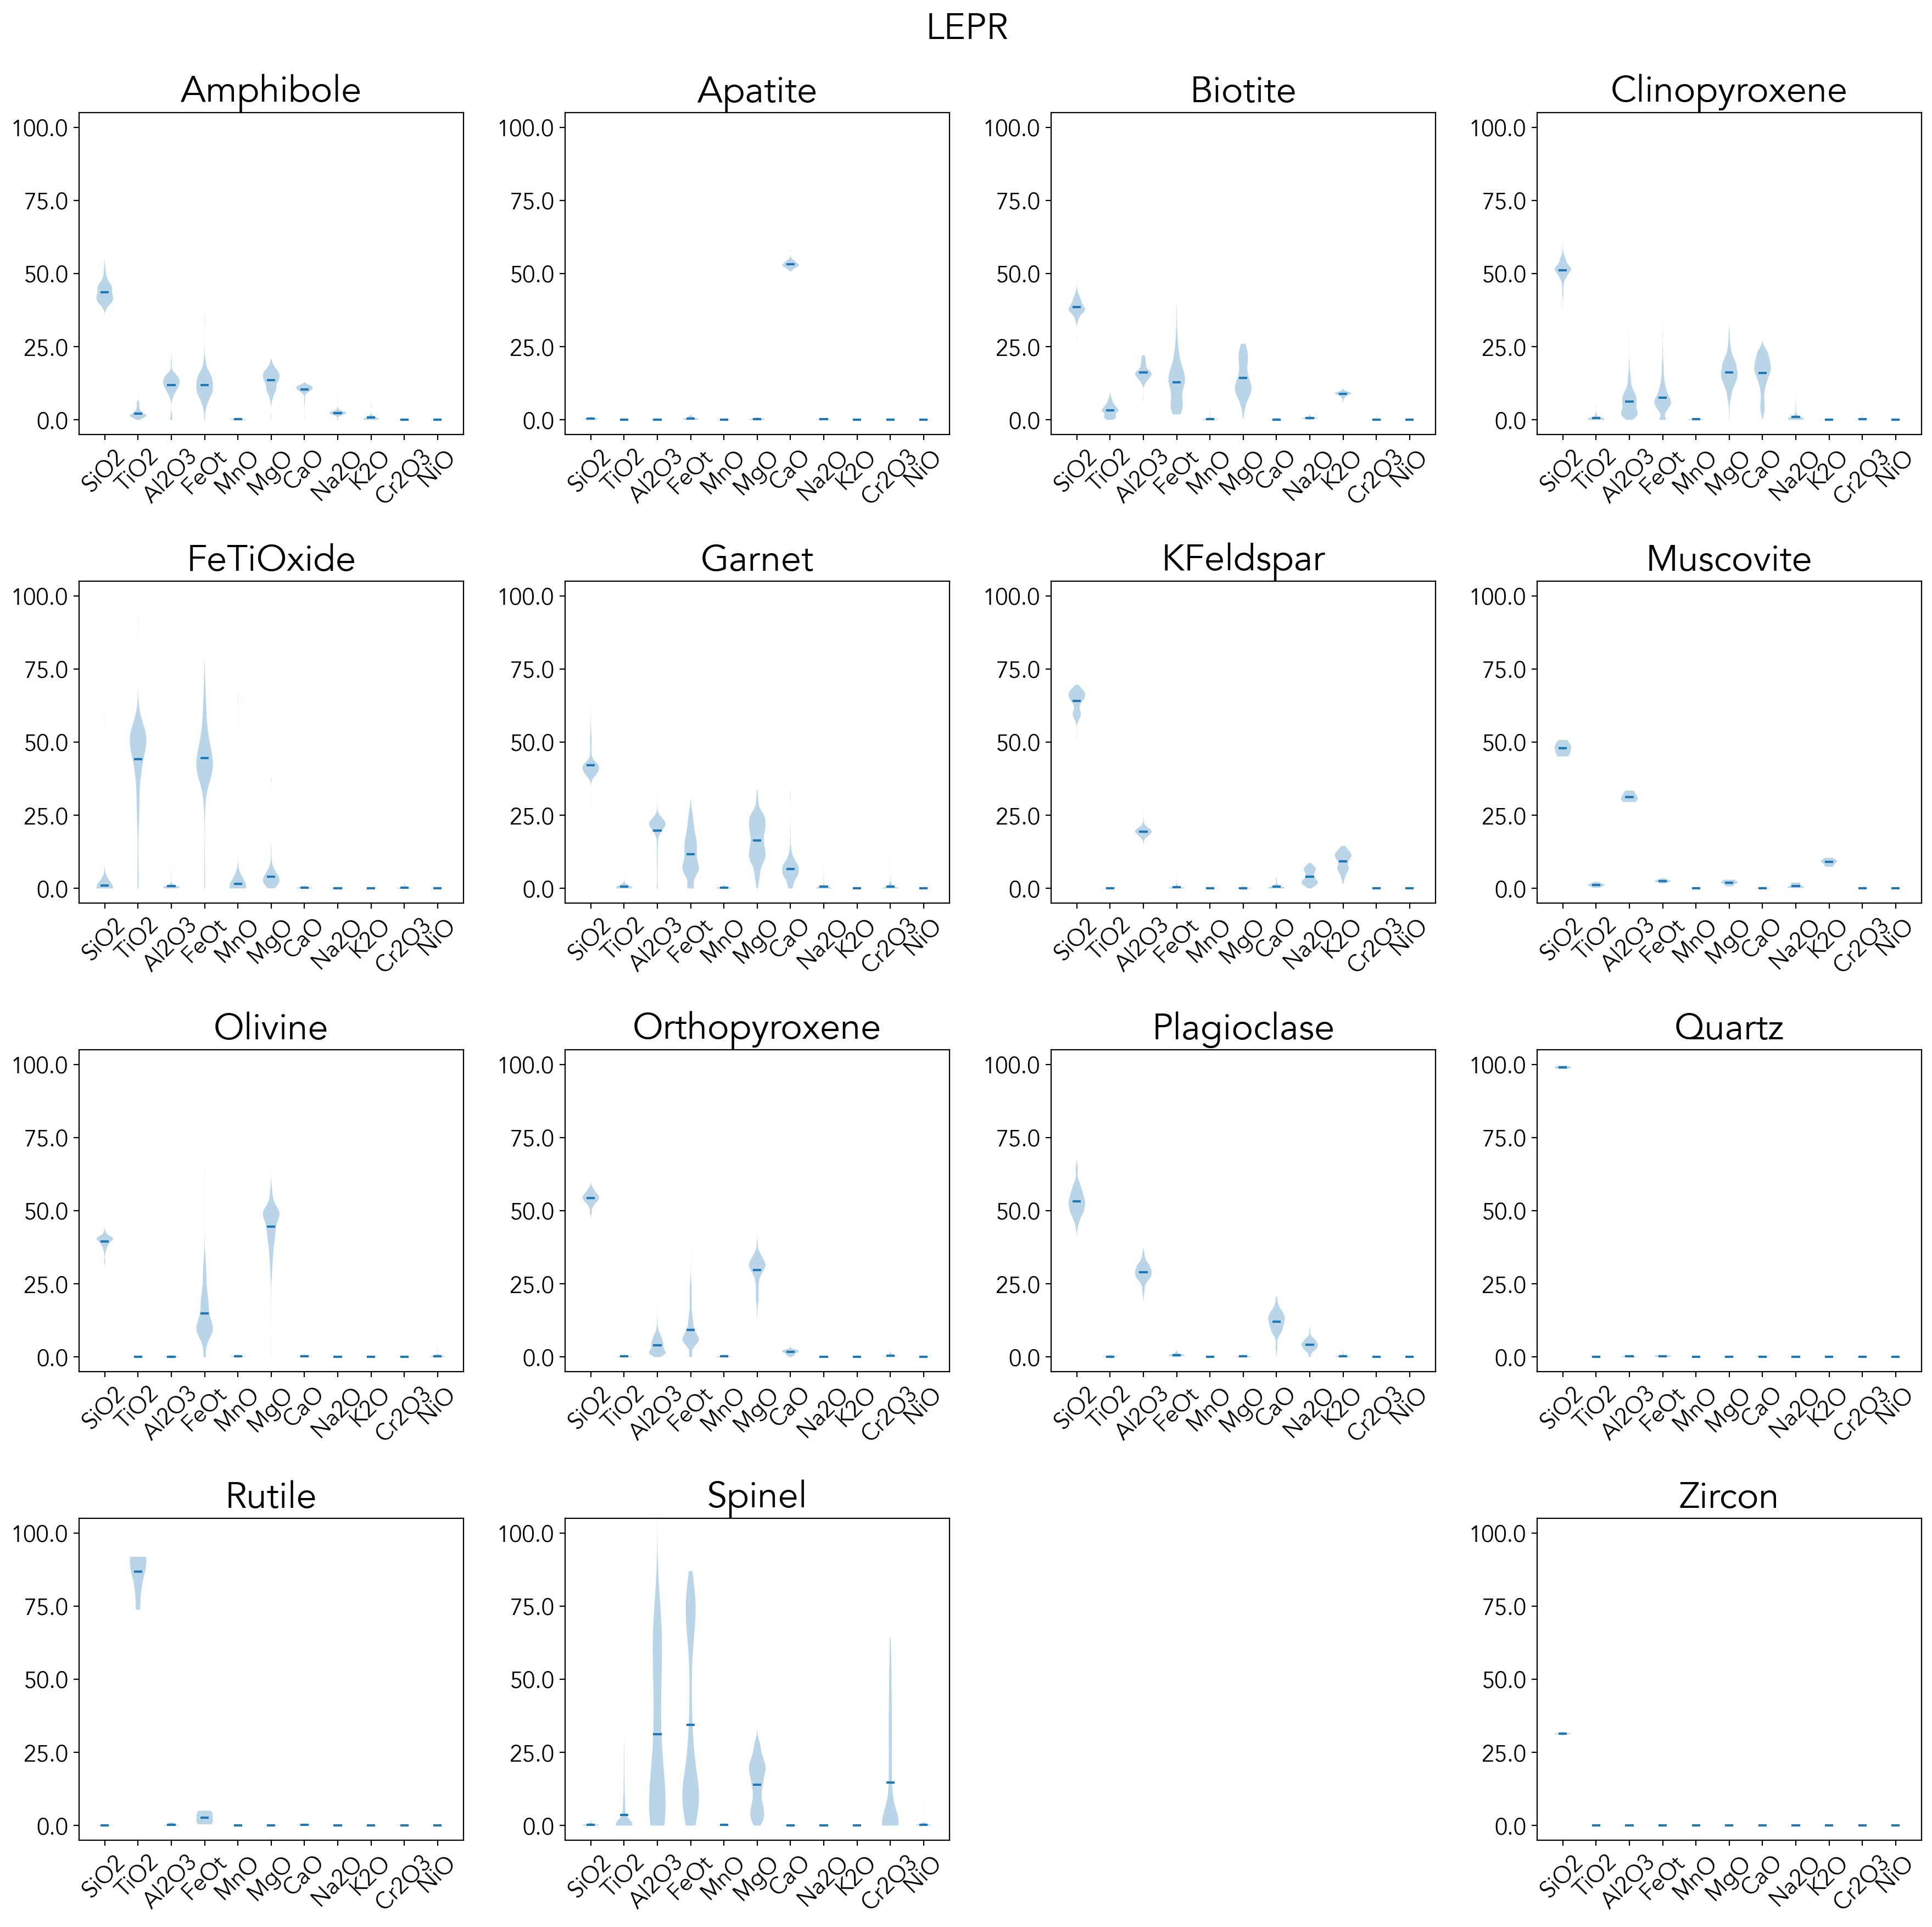

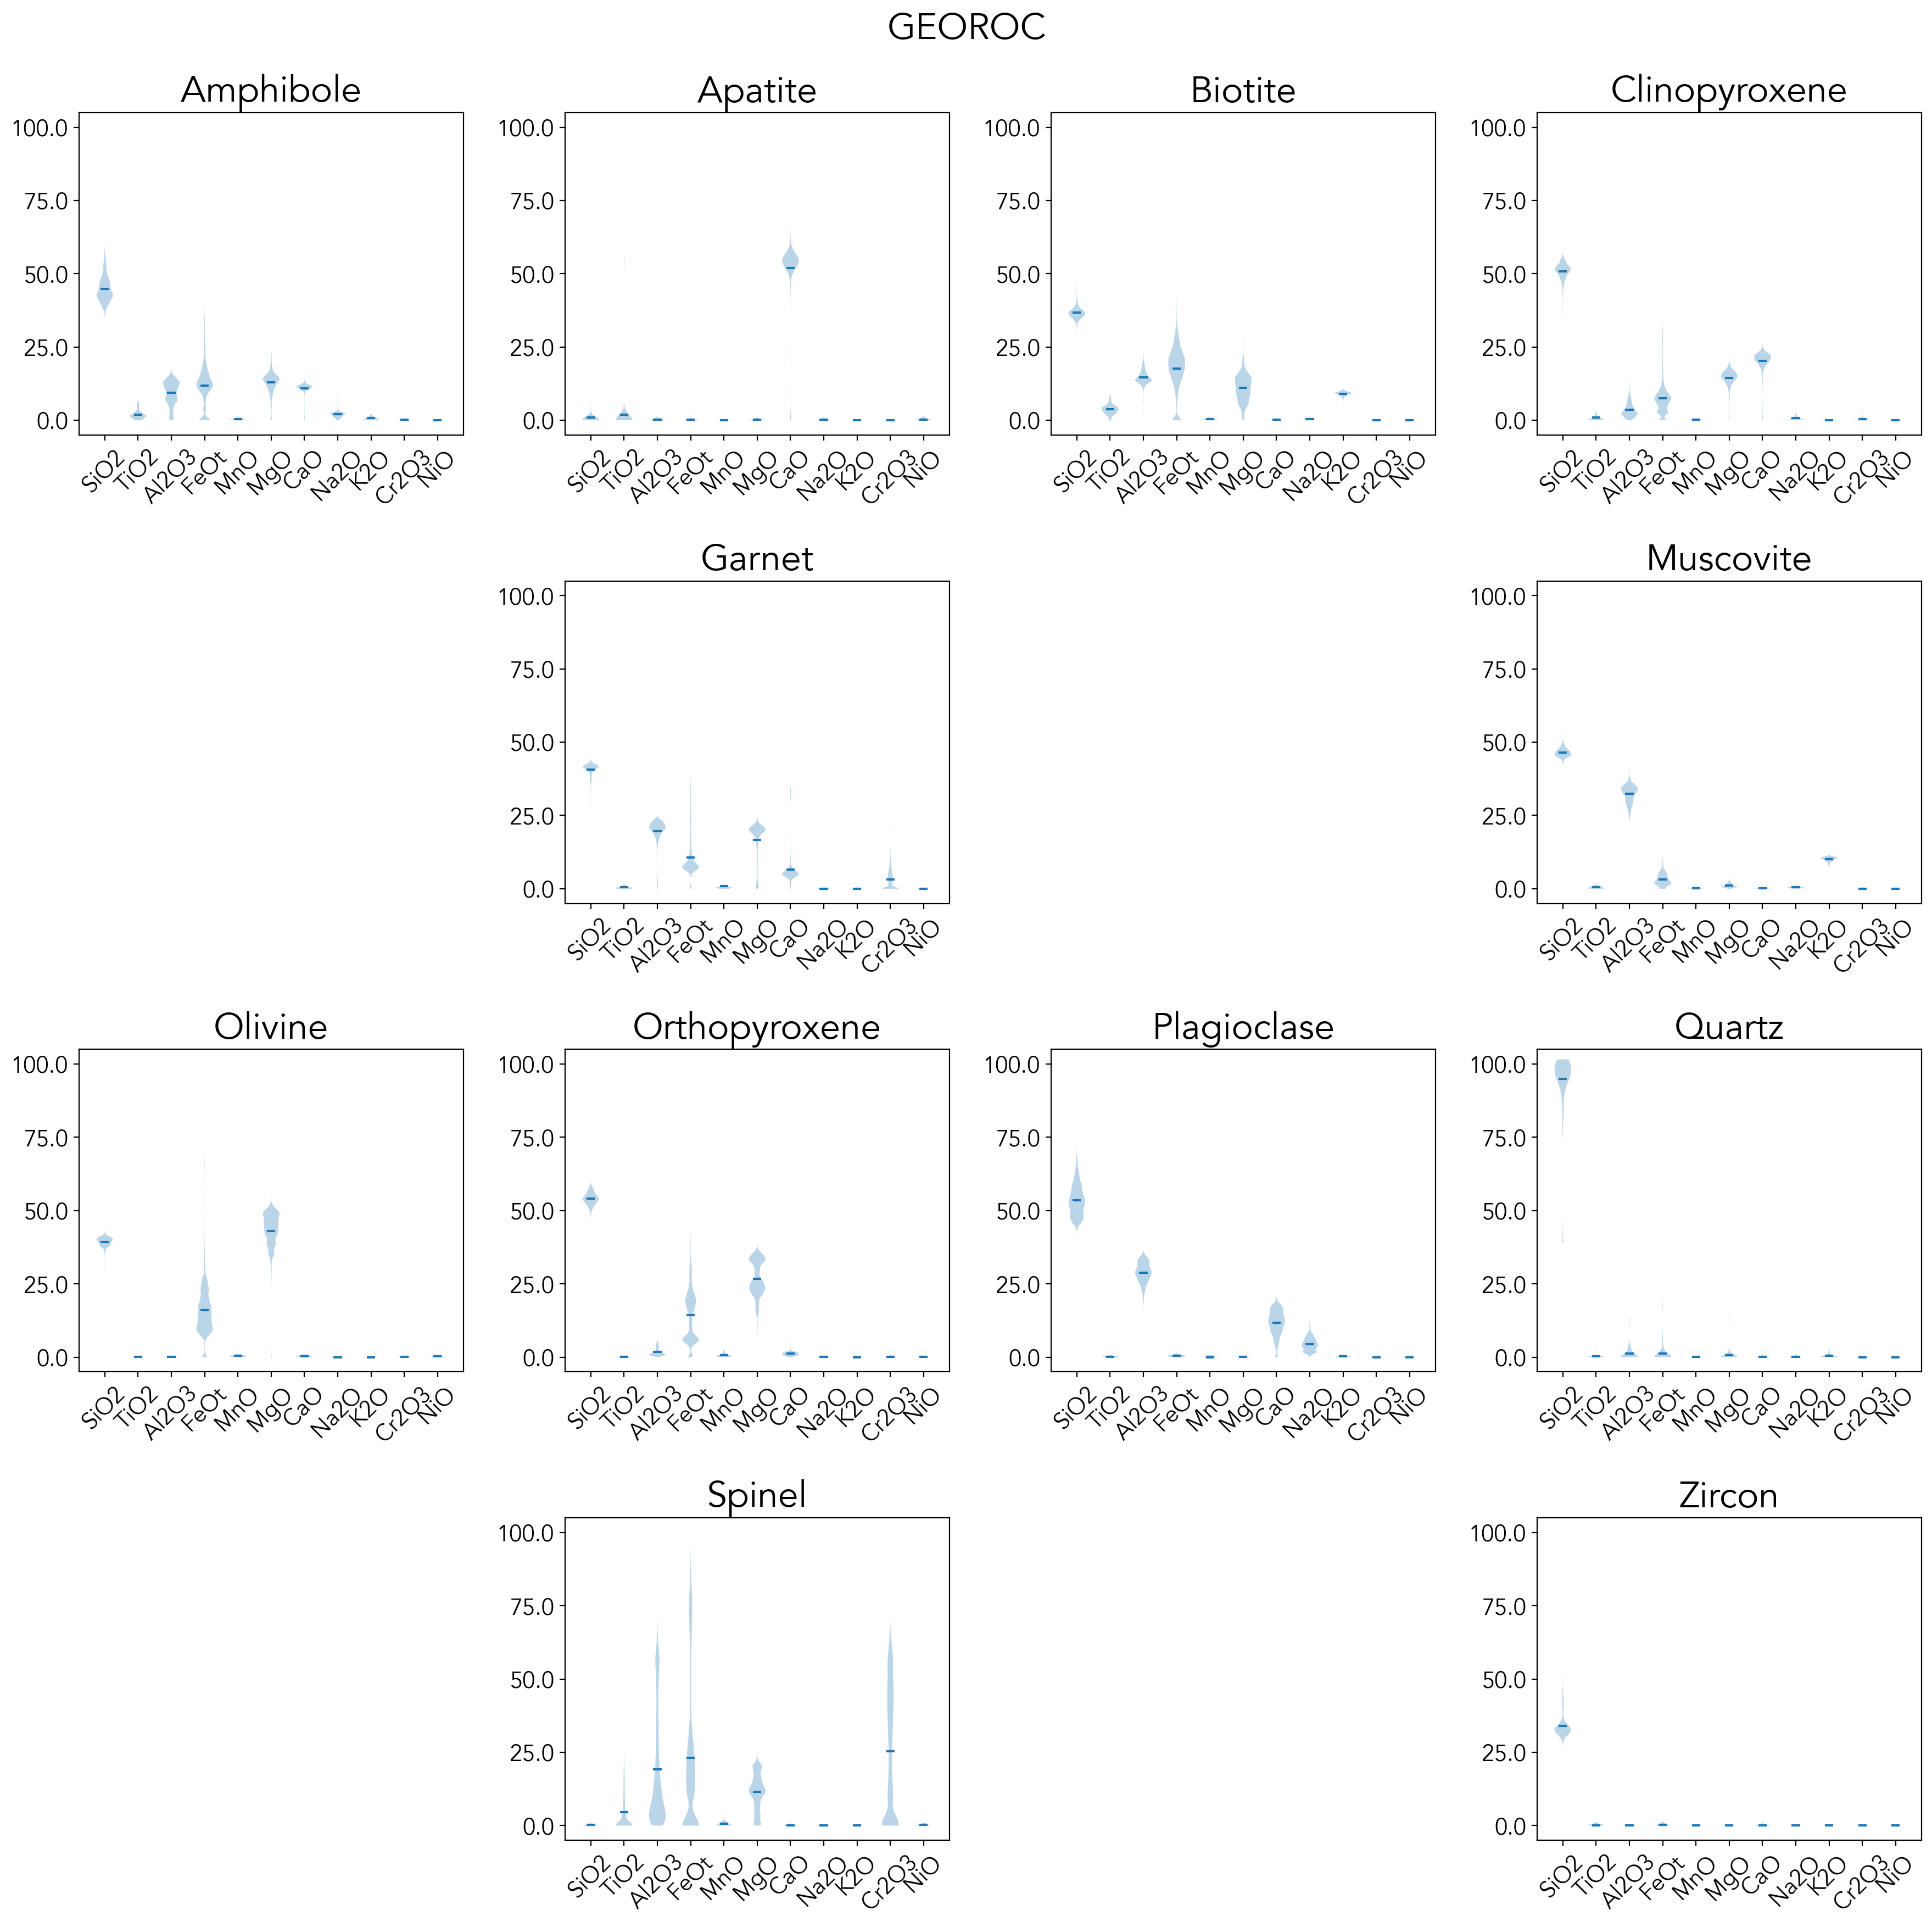

In [3]:
min_df = pd.read_csv('Training_Data/mindf_filt.csv')

oxideslab = ['SiO2', 'TiO2', 'Al2O3', 'FeOt', 'MnO', 'MgO', 'CaO', 'Na2O', 'K2O', 'Cr2O3', 'NiO', 'Mineral']
oxides = oxideslab[:-1]

df = min_df[oxideslab].copy()
df = df.fillna(0)
df_ox = df[oxides]
mins = np.unique(df['Mineral'])

phase = np.array(['Amphibole', 'Apatite', 'Biotite', 'Clinopyroxene', 'FeTiOxide',
        'Garnet', 'KFeldspar', 'Muscovite', 'Olivine', 'Orthopyroxene',
        'Plagioclase', 'Quartz', 'Rutile', 'Spinel', 'Tourmaline',
        'Zircon'])

fig, ax = plt.subplots(4, 4, figsize=(18, 18))
ax = ax.flatten()
for i in range(len(phase)): 
    if (df['Mineral'] == phase[i]).sum() > 0:

        ax[i].violinplot(df[df['Mineral']==phase[i]][oxides], positions = np.linspace(0, 10, 11), showmeans = True, showextrema= False)
        ax[i].set_title(phase[i])
        ax[i].set_xticks(np.linspace(0, 10, 11))
        ax[i].set_xticklabels(oxides, rotation = 45, fontsize = 15)
        ax[i].set_ylim([-5, 105])
        ax[i].set_yticklabels(ax[i].get_yticks(), fontsize = 15)
fig.suptitle('Training')
plt.tight_layout()
# plt.savefig('Training_Min.pdf')

lepr_df = pd.read_csv('Validation_Data/lepr_allphases_lim.csv')
lepr_df = lepr_df.dropna(subset=['SiO2', 'TiO2', 'Al2O3', 'FeOt', 'MnO', 'MgO', 'CaO', 'Na2O', 'K2O', 'Cr2O3', 'NiO'], thresh = 6)

oxideslab = ['SiO2', 'TiO2', 'Al2O3', 'FeOt', 'MnO', 'MgO', 'CaO', 'Na2O', 'K2O', 'Cr2O3', 'NiO', 'Mineral']
oxides = oxideslab[:-1]

lepr_df = lepr_df[oxideslab].copy()
lepr_df = lepr_df.fillna(0)
lepr_df_ox = lepr_df[oxides]
mins = np.unique(lepr_df['Mineral'])

phase = np.array(['Amphibole', 'Apatite', 'Biotite', 'Clinopyroxene', 'FeTiOxide',
        'Garnet', 'KFeldspar', 'Muscovite', 'Olivine', 'Orthopyroxene',
        'Plagioclase', 'Quartz', 'Rutile', 'Spinel', 'Tourmaline',
        'Zircon'])

fig, ax = plt.subplots(4, 4, figsize=(18, 18))
ax = ax.flatten()

for i in range(len(phase)):
    if phase[i] in mins:
        ax[i].violinplot(lepr_df[lepr_df['Mineral']==phase[i]][oxides], positions = np.linspace(0, 10, 11), showmeans = True, showextrema= False)
        ax[i].set_title(phase[i])
        ax[i].set_xticks(np.linspace(0, 10, 11))
        ax[i].set_xticklabels(oxides, rotation = 45, fontsize = 15)
        ax[i].set_ylim([-5, 105])
        ax[i].set_yticklabels(ax[i].get_yticks(), fontsize = 15)
    else:
        ax[i].axis('off')  # create empty subplots for minerals that don't exist
fig.suptitle('LEPR')
plt.tight_layout()
# plt.savefig('LEPR_Min.pdf')


georoc_df = pd.read_csv('Validation_Data/GEOROC_validationdata.csv')
georoc_df = georoc_df.dropna(subset=['SiO2', 'TiO2', 'Al2O3', 'FeOt', 'MnO', 'MgO', 'CaO', 'Na2O', 'K2O', 'Cr2O3', 'NiO'], thresh = 6)

oxideslab = ['SiO2', 'TiO2', 'Al2O3', 'FeOt', 'MnO', 'MgO', 'CaO', 'Na2O', 'K2O', 'Cr2O3', 'NiO', 'Mineral']
oxides = oxideslab[:-1]

georoc_df = georoc_df[oxideslab].copy()
georoc_df = georoc_df.fillna(0)
georoc_df_ox = georoc_df[oxides]
mins = np.unique(georoc_df['Mineral'])

phase = np.array(['Amphibole', 'Apatite', 'Biotite', 'Clinopyroxene', 'FeTiOxide',
        'Garnet', 'KFeldspar', 'Muscovite', 'Olivine', 'Orthopyroxene',
        'Plagioclase', 'Quartz', 'Rutile', 'Spinel', 'Tourmaline',
        'Zircon'])

fig, ax = plt.subplots(4, 4, figsize=(18, 18))
ax = ax.flatten()

for i in range(len(phase)):
    if phase[i] in mins:
        ax[i].violinplot(georoc_df[georoc_df['Mineral']==phase[i]][oxides], positions = np.linspace(0, 10, 11), showmeans = True, showextrema= False)
        ax[i].set_title(phase[i])
        ax[i].set_xticks(np.linspace(0, 10, 11))
        ax[i].set_xticklabels(oxides, rotation = 45, fontsize = 15)
        ax[i].set_ylim([-5, 105])
        ax[i].set_yticklabels(ax[i].get_yticks(), fontsize = 15)
    else:
        ax[i].axis('off')  # create empty subplots for minerals that don't exist
fig.suptitle('GEOROC')
plt.tight_layout()
# plt.savefig('GEOROC_Min.pdf')

In [4]:
oxides = ['SiO2', 'TiO2', 'Al2O3', 'FeOt', 'MnO', 'MgO', 'CaO', 'Na2O', 'K2O', 'Cr2O3']
georoc = pd.read_csv('Validation_Data/GEOROC_validationdata.csv', index_col=0)
georoc_df = georoc.dropna(subset=oxides, thresh = 6)

georoc_df = georoc_df[georoc_df.Mineral.isin(['Amphibole', 'Apatite', 'Biotite', 'Clinopyroxene', 'Garnet', 'FeTiOxide', 'Ilmenite', 'KFeldspar', 'Magnetite', 'Muscovite', 'Olivine', 'Orthopyroxene','Plagioclase', 'Quartz', 'Rutile', 'Spinel', 'Tourmaline', 'Zircon'])]

lepr = pd.read_csv('Validation_Data/lepr_allphases_lim.csv', index_col=0)
lepr_df = lepr.dropna(subset=oxides, thresh = 6)

<ipython-input-4-7007c350e713>:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  georoc = pd.read_csv('Validation_Data/GEOROC_validationdata.csv', index_col=0)


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

oxides = ['SiO2', 'TiO2', 'Al2O3', 'FeOt', 'MnO', 'MgO', 'CaO', 'Na2O', 'K2O', 'Cr2O3']

name = 'mindf_256_64_16_noP'
path = 'autoencoder_parametermatrix/' + name + '_tanh_params.pt'
model = Tanh_Autoencoder(input_dim=10, hidden_layer_sizes=(256, 64, 16)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=0)
load_model(model, optimizer, path)

georoc_wt = georoc_df[oxides].fillna(0)
georoc_wt = georoc_wt.to_numpy()
ss1 = StandardScaler()
georoc_norm_wt = ss1.fit_transform(georoc_wt)
z_georoc = getLatent(model, georoc_norm_wt)

lepr_wt = lepr_df[oxides].fillna(0)
lepr_wt = lepr_wt.to_numpy()
ss2 = StandardScaler()
lepr_norm_wt = ss2.fit_transform(lepr_wt)
z_lepr = getLatent(model, lepr_norm_wt)

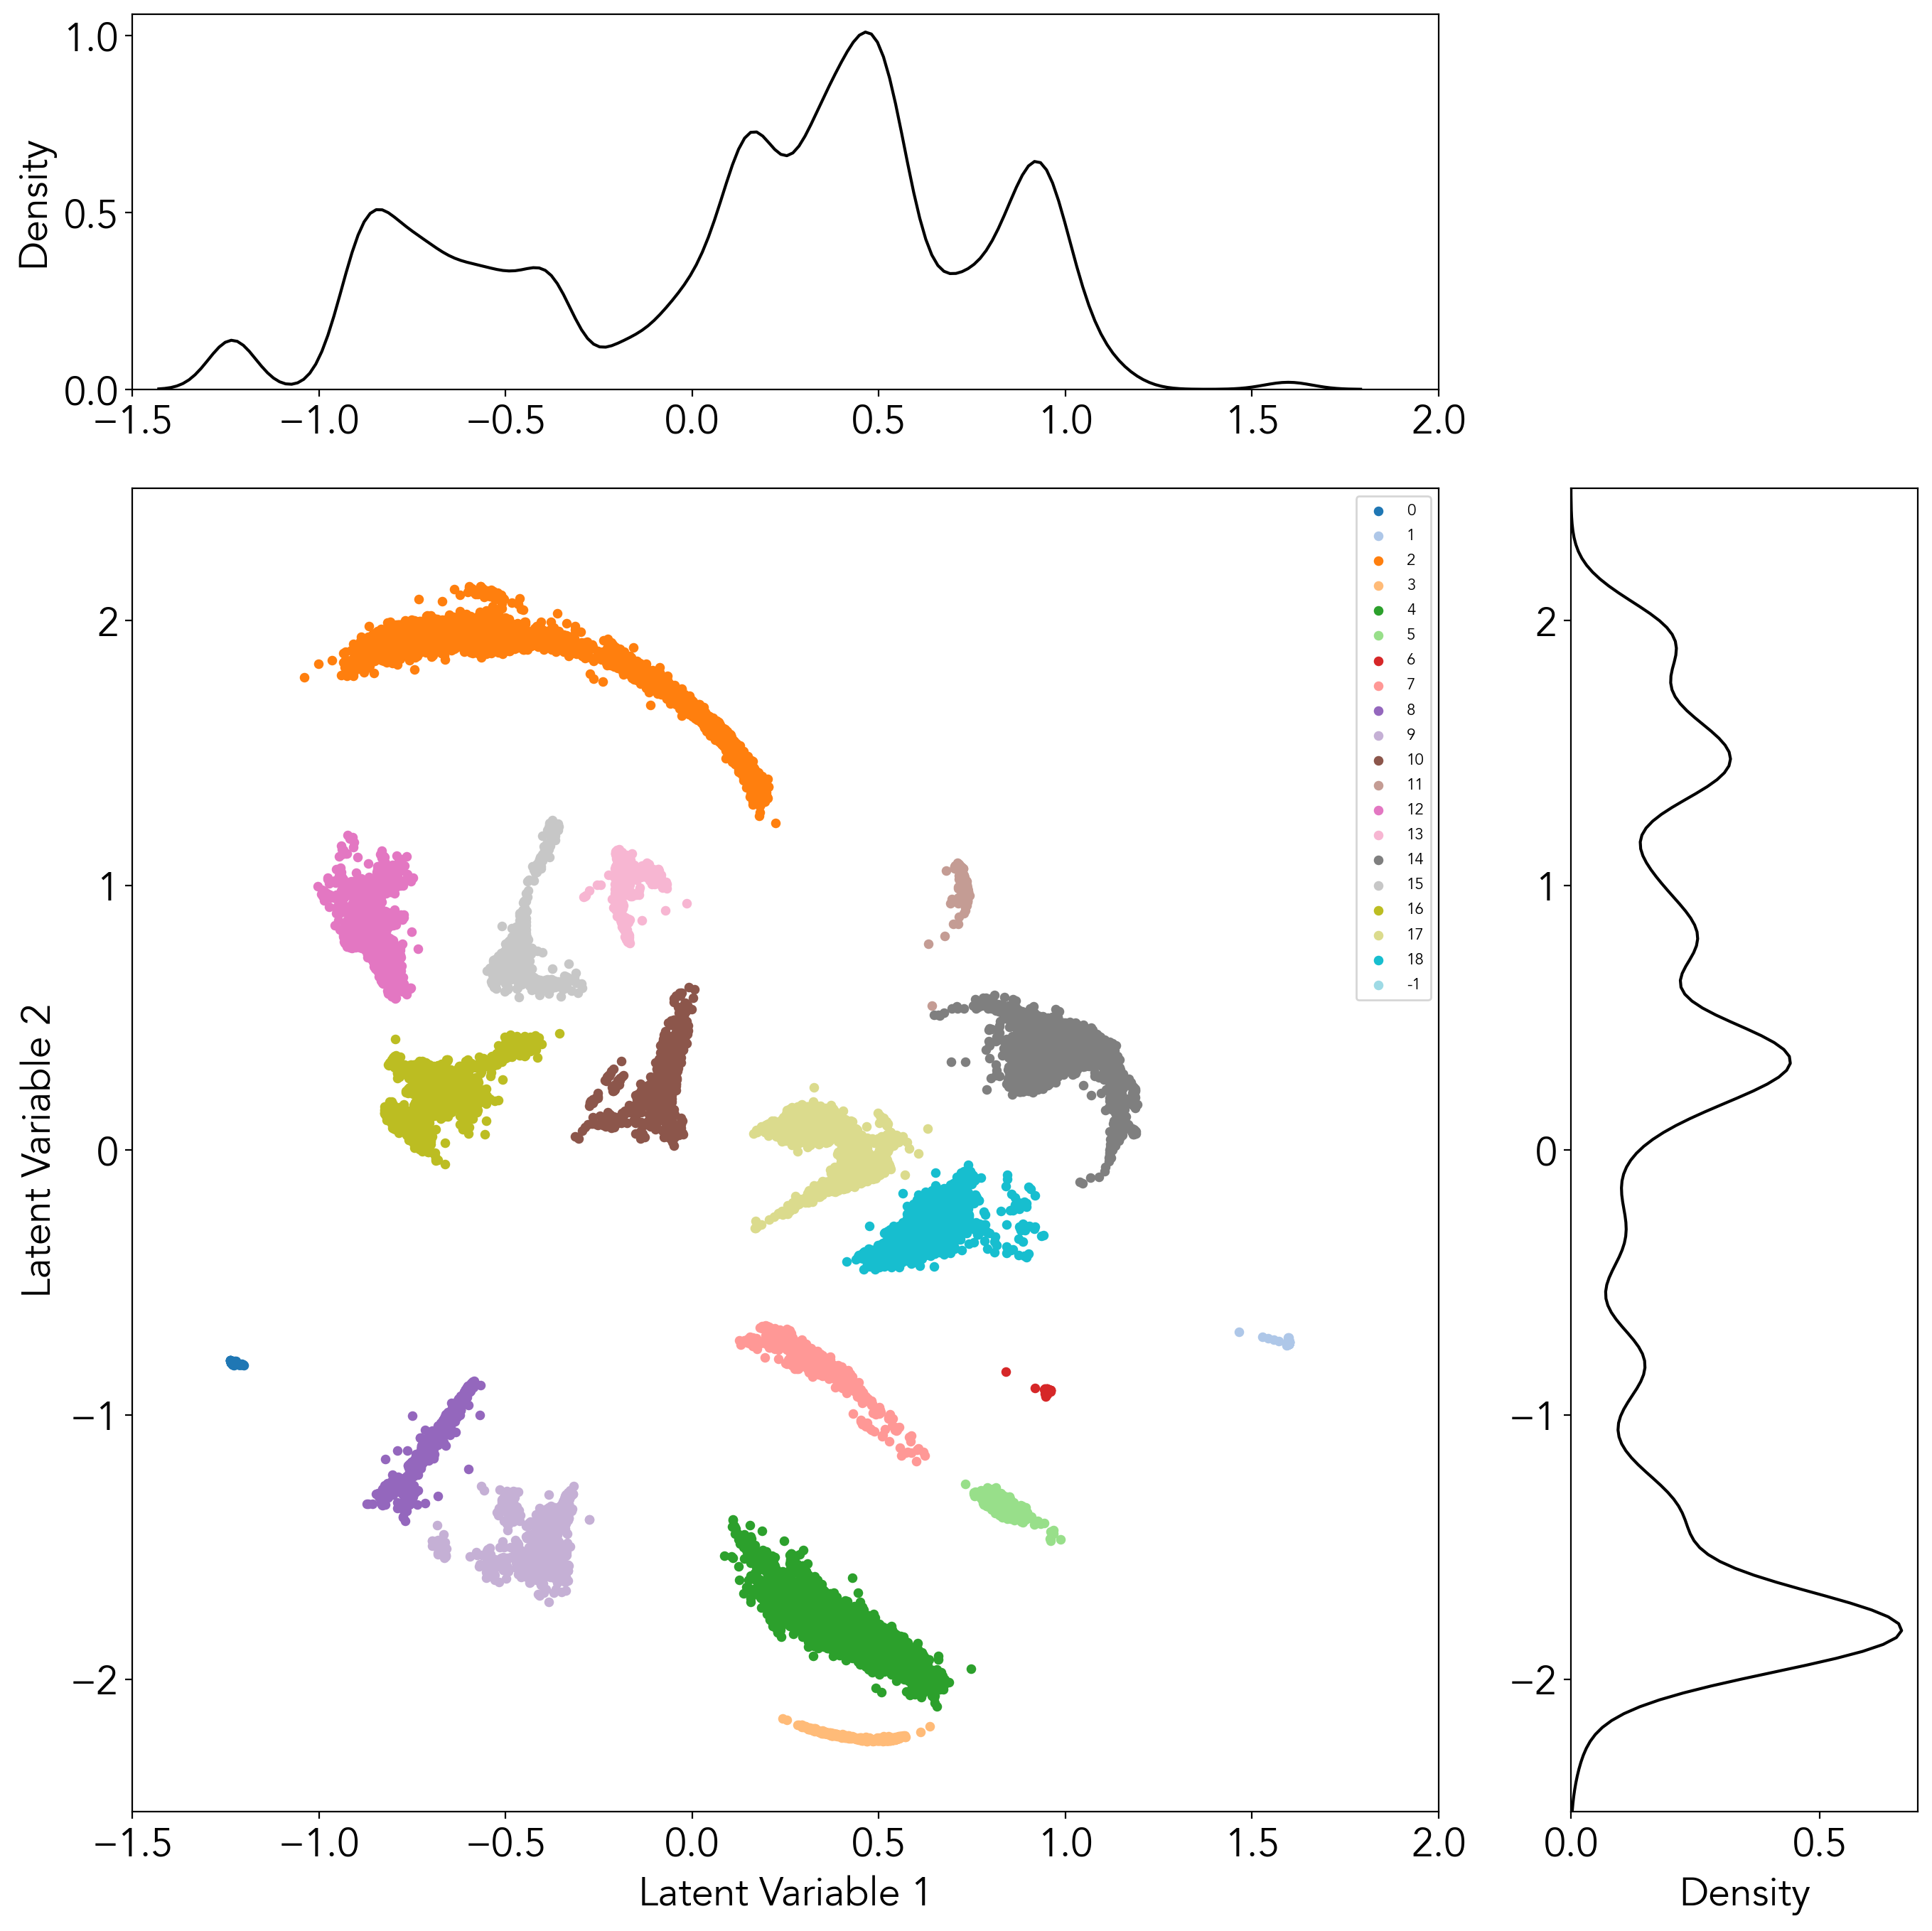

In [6]:
name = 'mindf_256_64_16'
min_df = pd.read_csv('Training_Data/mindf_filt.csv')
z = np.load('autoencoder_parametermatrix/' + name + '_tanh.npz')['z']

array, params = feature_normalisation(z, return_params = True)

clusterer = HDBSCAN_flat(array, min_cluster_size=30, cluster_selection_epsilon=0.025, prediction_data=True)
labels = clusterer.labels_
probs = clusterer.probabilities_

np.savez('autoencoder_parametermatrix/' + name + '_hdbscan_flat.npz', labels = labels, probs = probs)

z_scores_df = pd.DataFrame(columns = ['LV1', 'LV2']) 
z_scores_df['LV1'] = z[:,0]
z_scores_df['LV2'] = z[:,1]

fig = plt.figure(figsize = (14, 14))
gs = GridSpec(4, 4)
ax_scatter = fig.add_subplot(gs[1:4, 0:3])
ax_hist_x = fig.add_subplot(gs[0,0:3])
ax_hist_y = fig.add_subplot(gs[1:4, 3])

phase = list(set(min_df['Mineral']))
tab = plt.get_cmap('tab20')
label_plot = list(set(labels))
cNorm  = mcolors.Normalize(vmin=0, vmax=len(label_plot))
labelscalarMap = mcm.ScalarMappable(norm=cNorm, cmap=tab)

for i in range(len(label_plot)):
    indx = labels == i
    ax_scatter.scatter(z[indx, 0], z[indx, 1], s=15, color=labelscalarMap.to_rgba(i), lw=1, label=label_plot[i], rasterized = True)
ax_scatter.set_xlabel("Latent Variable 1")
ax_scatter.set_ylabel("Latent Variable 2")
ax_scatter.set_xlim([-1.5, 2.0])
ax_scatter.set_ylim([-2.5, 2.5])
ax_scatter.legend(prop={'size': 8})

pc1_sns = sns.kdeplot(data = z_scores_df, x = 'LV1', color = 'k', ax = ax_hist_x)
pc1_sns.set_xlim([-1.5, 2.0])
pc1_sns.set(xlabel = None)

pc2_sns = sns.kdeplot(data = z_scores_df, y = 'LV2', color = 'k')
pc2_sns.set_ylim([-2.5, 2.5])
pc2_sns.set(ylabel = None)

plt.tight_layout()

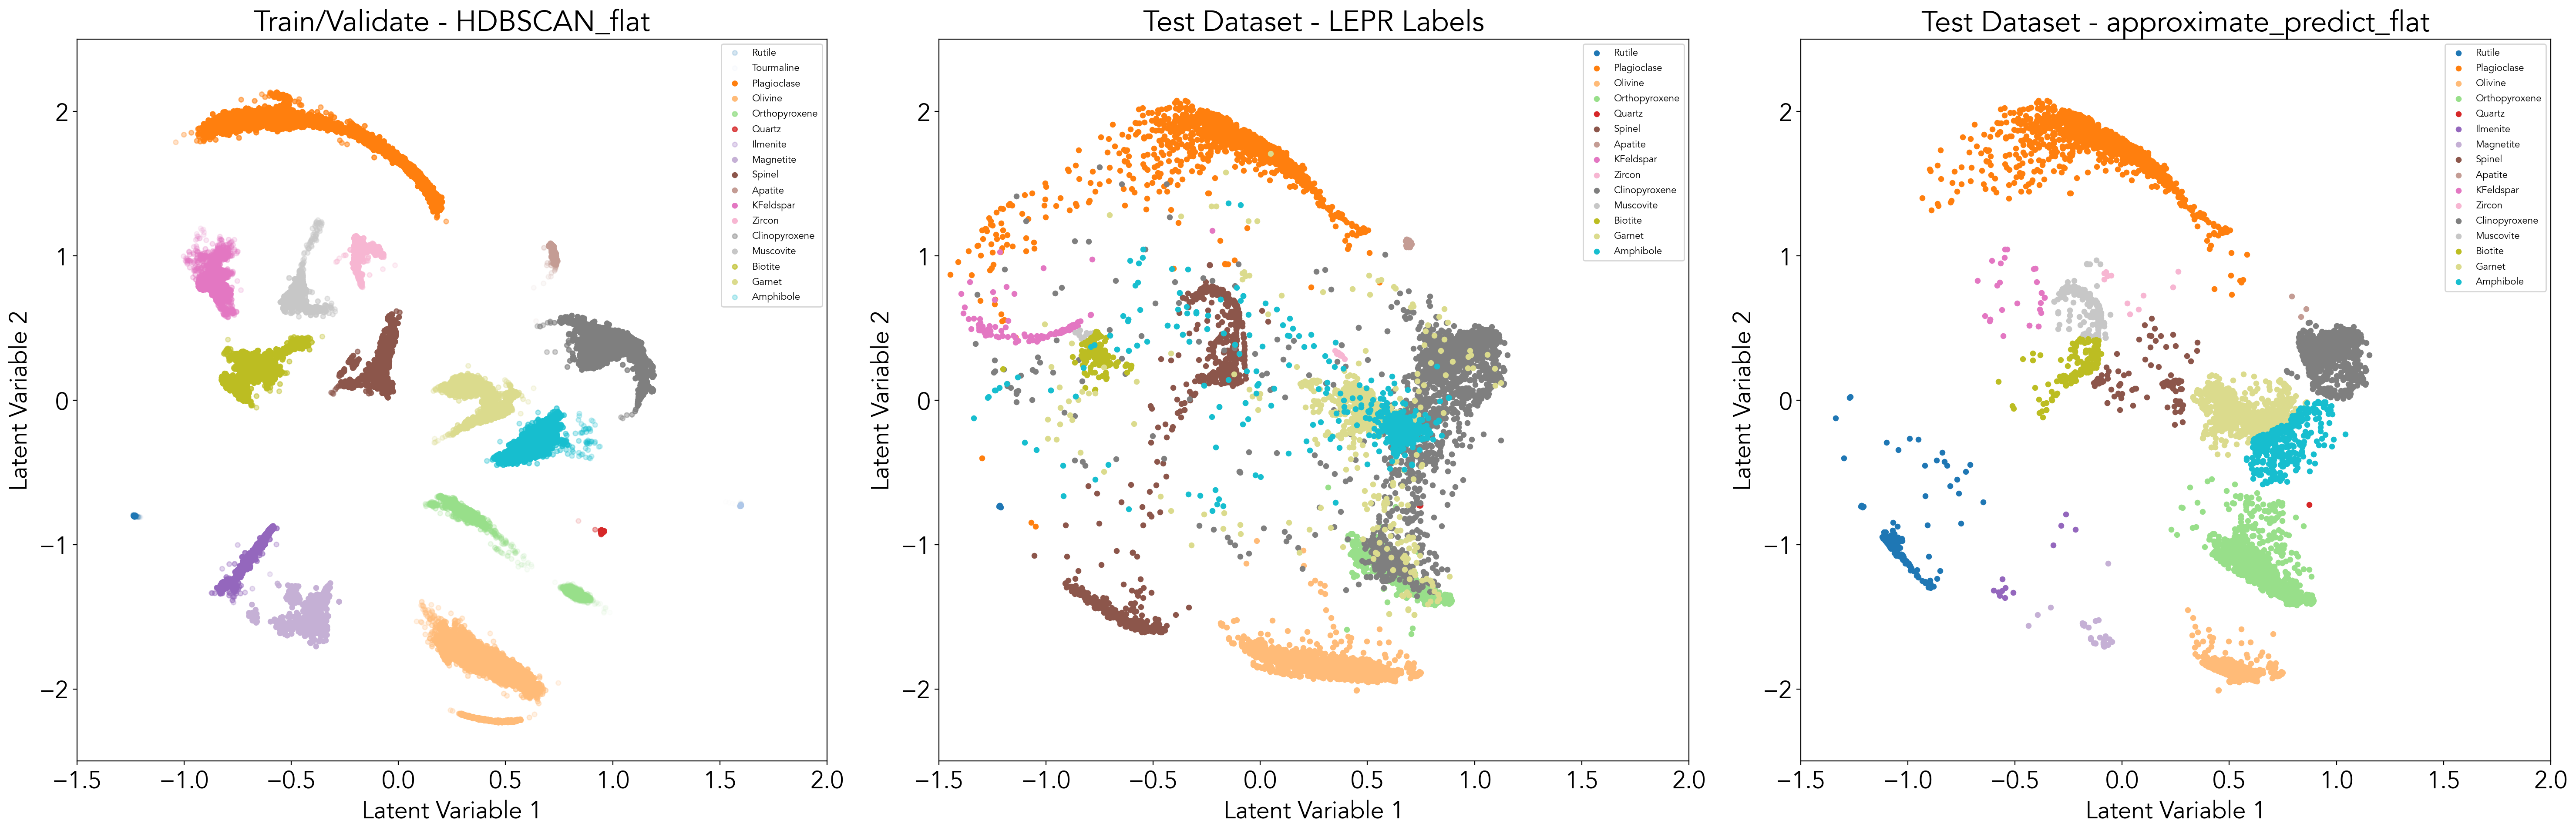

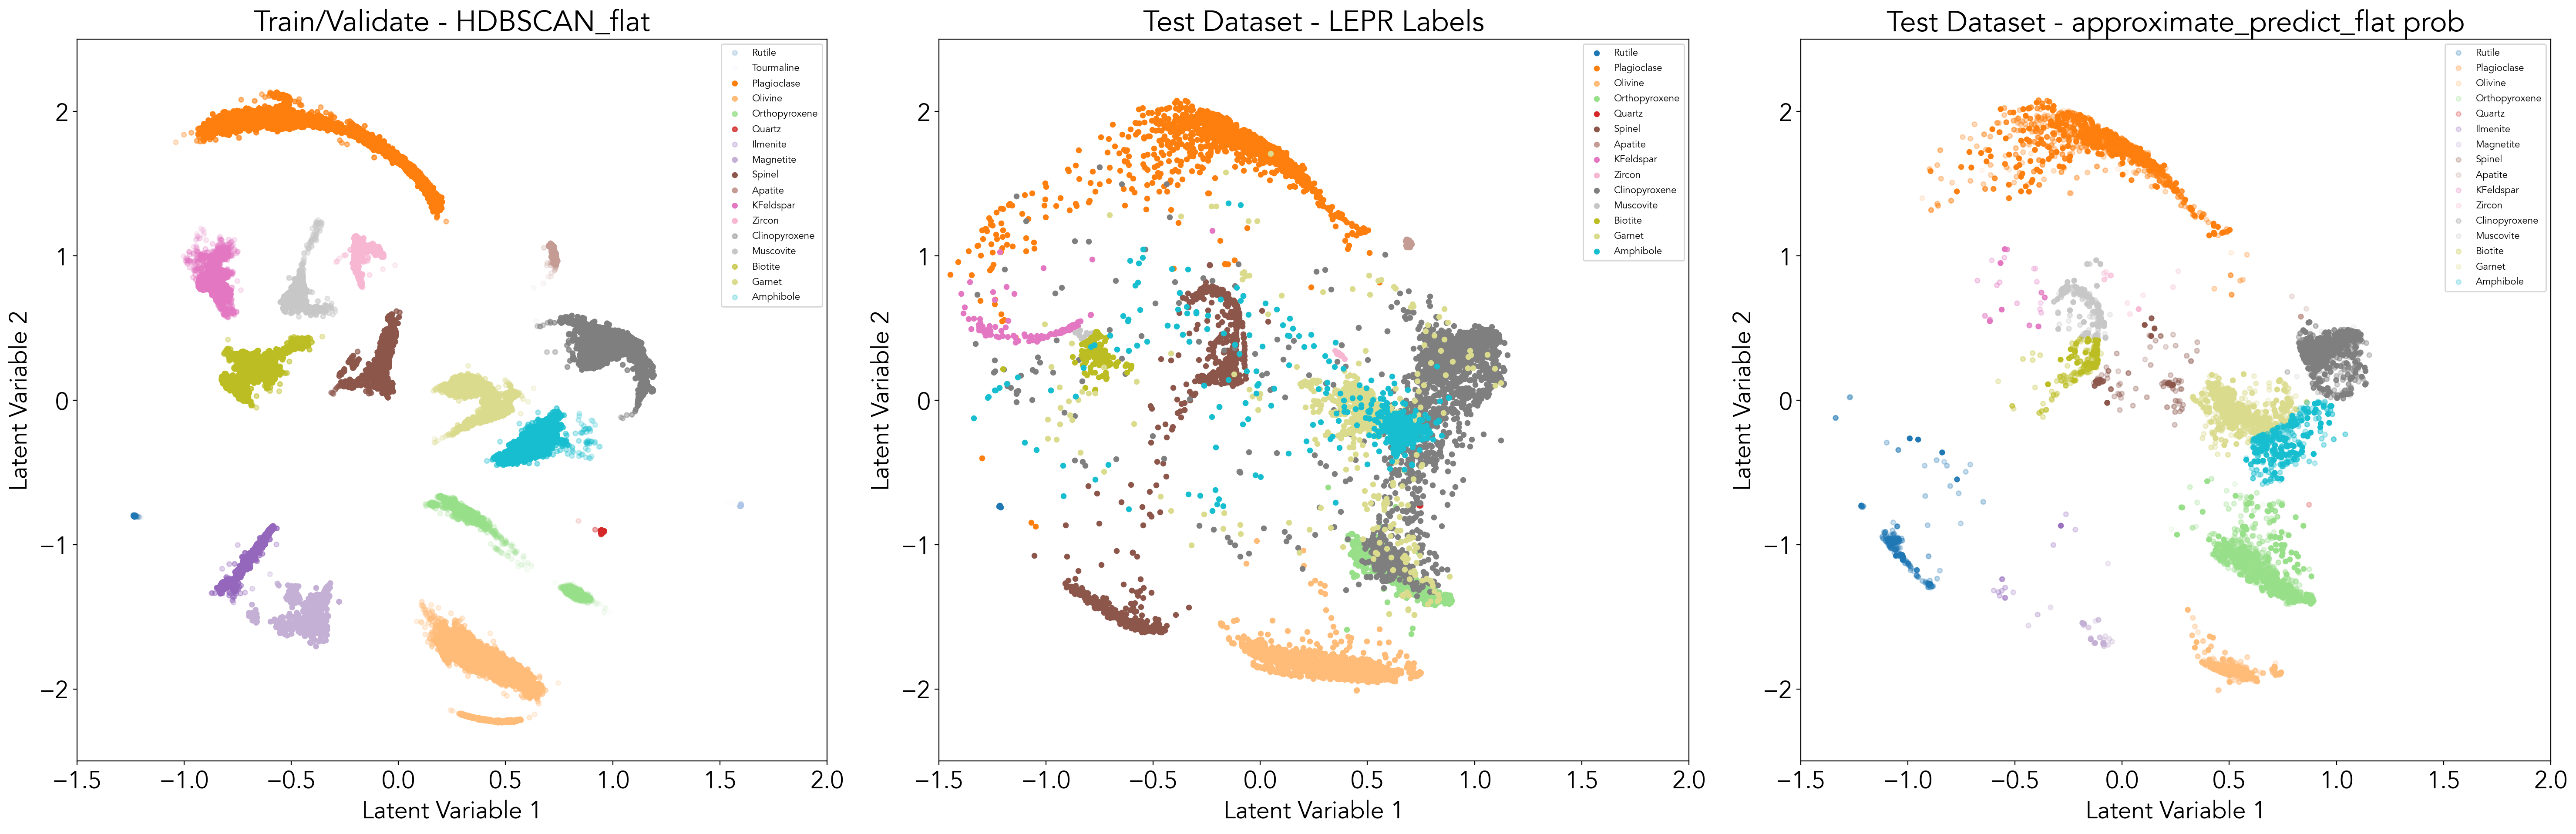

In [7]:
name = 'mindf_256_64_16'
min_df = pd.read_csv('Training_Data/mindf_filt.csv')
z = np.load('autoencoder_parametermatrix/' + name + '_tanh.npz')['z']
z_lepr = getLatent(model, lepr_norm_wt)

array, params = feature_normalisation(z, return_params = True)
clusterer = HDBSCAN_flat(array, min_cluster_size=30, cluster_selection_epsilon=0.025, prediction_data=True)
labels, probs = clusterer.labels_, clusterer.probabilities_
array_filt = array[labels!=-1]
labels_filt = labels[labels!=-1]
probs_filt = probs[labels!=-1]
labels[labels==7] = 5 # combine opx
labels[labels==4] = 3 # combine olivine

array_lepr, params_lepr = feature_normalisation(z_lepr, return_params = True)
labels_lepr, probs_lepr = approximate_predict_flat(clusterer, array_lepr, cluster_selection_epsilon=0.025)
array_lepr_filt = array_lepr[labels_lepr!=-1]
labels_lepr_filt = labels_lepr[labels_lepr!=-1]
z_lepr_filt = z_lepr[labels_lepr!=-1]
labels_lepr_filt[labels_lepr_filt==7] = 5
labels_lepr_filt[labels_lepr_filt==4] = 3

tab = plt.get_cmap('tab20')
label_plot = list(set(labels_filt))
label_lepr_plot = list(set(labels_lepr_filt))
cNorm  = mcolors.Normalize(vmin=0, vmax=len(label_plot))
scalarMap = mcm.ScalarMappable(norm=cNorm, cmap=tab)
phase = np.array(['Rutile', 'Tourmaline', 'Plagioclase', 'Olivine', 'Olivine1', 'Orthopyroxene', 'Quartz', 'Orthopyroxene1', 'Ilmenite', 'Magnetite', 'Spinel', 'Apatite', 'KFeldspar', 'Zircon', 'Clinopyroxene', 'Muscovite', 'Biotite', 'Garnet', 'Amphibole'])
label_to_color_idx = {label: idx for idx, label in enumerate(label_plot)}
cluster_to_label = {i: phase[i] for i in label_plot}

fig, ax = plt.subplots(1, 3, figsize = (30, 10))
ax = ax.flatten()

for label in label_plot:
    indx = labels == label
    if np.any(indx):  # Add this condition
        alphas = probs[indx]
        ax[0].scatter(z[indx, 0], z[indx, 1], s=15, color=scalarMap.to_rgba(label_to_color_idx[label]), lw=1, label=cluster_to_label[label], alpha=alphas)

for i in range(len(phase)):
    indx = lepr_df['Mineral'] == phase[i]
    if np.any(indx):  # Add this condition
        ax[1].scatter(z_lepr[indx, 0], z_lepr[indx, 1], s=15, color=scalarMap.to_rgba(i), lw=1, label=phase[i])

for label in label_lepr_plot:
    indx = labels_lepr_filt == label
    if np.any(indx):  # Add this condition
        # alphas=probs_lepr
        ax[2].scatter(z_lepr_filt[indx, 0], z_lepr_filt[indx, 1], s=15, color=scalarMap.to_rgba(label_to_color_idx[label]), lw=1, label=cluster_to_label[label]) #, alpha=alphas)

ax[0].set_title("Train/Validate - HDBSCAN_flat")
ax[0].set_xlabel("Latent Variable 1")
ax[0].set_ylabel("Latent Variable 2")
ax[0].set_xlim([-1.5, 2.0])
ax[0].set_ylim([-2.5, 2.5])
ax[0].legend(prop={'size': 8})

ax[1].set_title("Test Dataset - LEPR Labels")
ax[1].set_xlabel("Latent Variable 1")
ax[1].set_ylabel("Latent Variable 2")
ax[1].set_xlim([-1.5, 2.0])
ax[1].set_ylim([-2.5, 2.5])
ax[1].legend(prop={'size': 8})

ax[2].set_title("Test Dataset - approximate_predict_flat")
ax[2].set_xlabel("Latent Variable 1")
ax[2].set_ylabel("Latent Variable 2")
ax[2].set_xlim([-1.5, 2.0])
ax[2].set_ylim([-2.5, 2.5])
ax[2].legend(prop={'size': 8})
plt.tight_layout()
plt.savefig('LEPR_HDBSCAN_flat.png', bbox_inches='tight', pad_inches = 0.025, dpi=300)



fig, ax = plt.subplots(1, 3, figsize = (30, 10))
ax = ax.flatten()

for label in label_plot:
    indx = labels == label
    if np.any(indx):  # Add this condition
        alphas = probs[indx]
        ax[0].scatter(z[indx, 0], z[indx, 1], s=15, color=scalarMap.to_rgba(label_to_color_idx[label]), lw=1, label=cluster_to_label[label], alpha=alphas)

for i in range(len(phase)):
    indx = lepr_df['Mineral'] == phase[i]
    if np.any(indx):  # Add this condition
        ax[1].scatter(z_lepr[indx, 0], z_lepr[indx, 1], s=15, color=scalarMap.to_rgba(i), lw=1, label=phase[i])

for label in label_lepr_plot:
    indx = labels_lepr_filt == label
    if np.any(indx):  # Add this condition
        alphas=probs_lepr
        ax[2].scatter(z_lepr_filt[indx, 0], z_lepr_filt[indx, 1], s=15, color=scalarMap.to_rgba(label_to_color_idx[label]), lw=1, label=cluster_to_label[label], alpha=alphas)

ax[0].set_title("Train/Validate - HDBSCAN_flat")
ax[0].set_xlabel("Latent Variable 1")
ax[0].set_ylabel("Latent Variable 2")
ax[0].set_xlim([-1.5, 2.0])
ax[0].set_ylim([-2.5, 2.5])
ax[0].legend(prop={'size': 8})

ax[1].set_title("Test Dataset - LEPR Labels")
ax[1].set_xlabel("Latent Variable 1")
ax[1].set_ylabel("Latent Variable 2")
ax[1].set_xlim([-1.5, 2.0])
ax[1].set_ylim([-2.5, 2.5])
ax[1].legend(prop={'size': 8})

ax[2].set_title("Test Dataset - approximate_predict_flat prob")
ax[2].set_xlabel("Latent Variable 1")
ax[2].set_ylabel("Latent Variable 2")
ax[2].set_xlim([-1.5, 2.0])
ax[2].set_ylim([-2.5, 2.5])
ax[2].legend(prop={'size': 8})
plt.tight_layout()
plt.savefig('LEPR_HDBSCAN_flat_probs.png', bbox_inches='tight', pad_inches = 0.025, dpi=300)

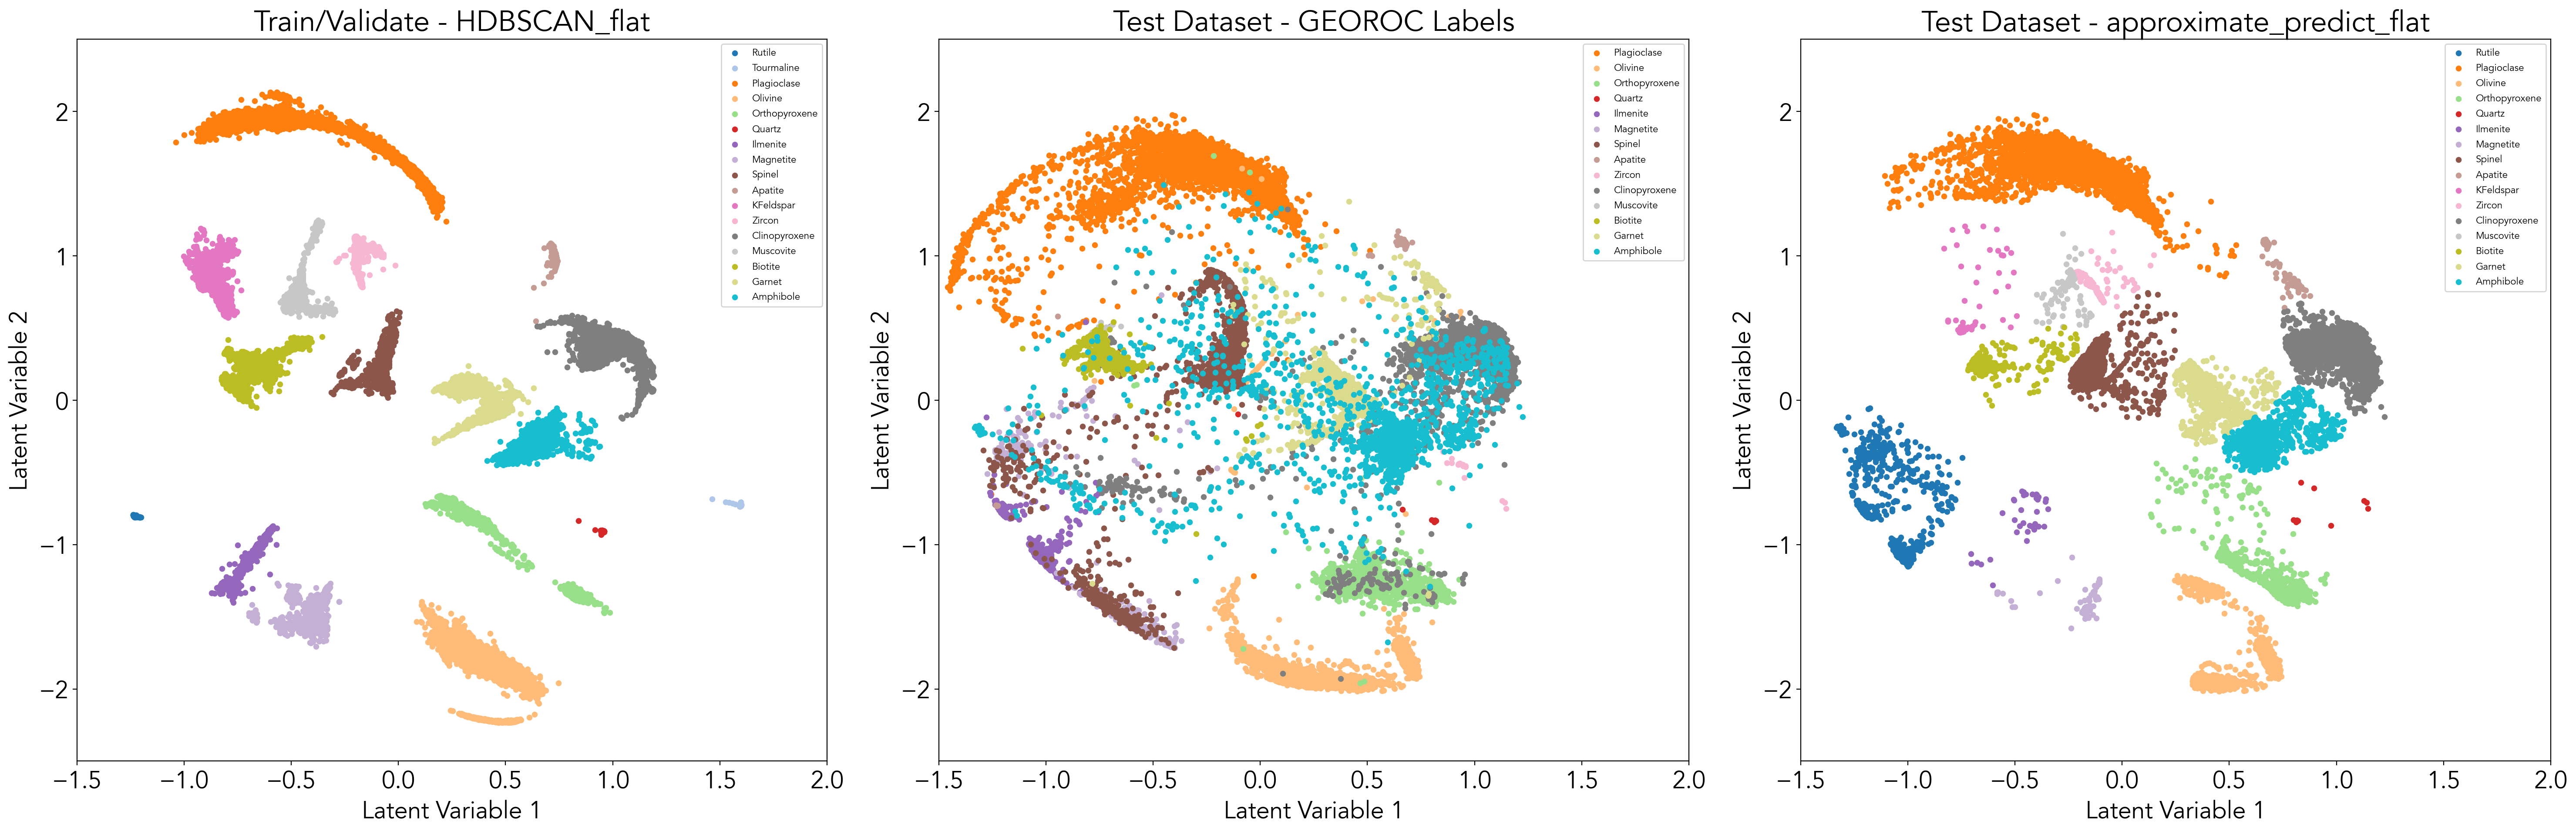

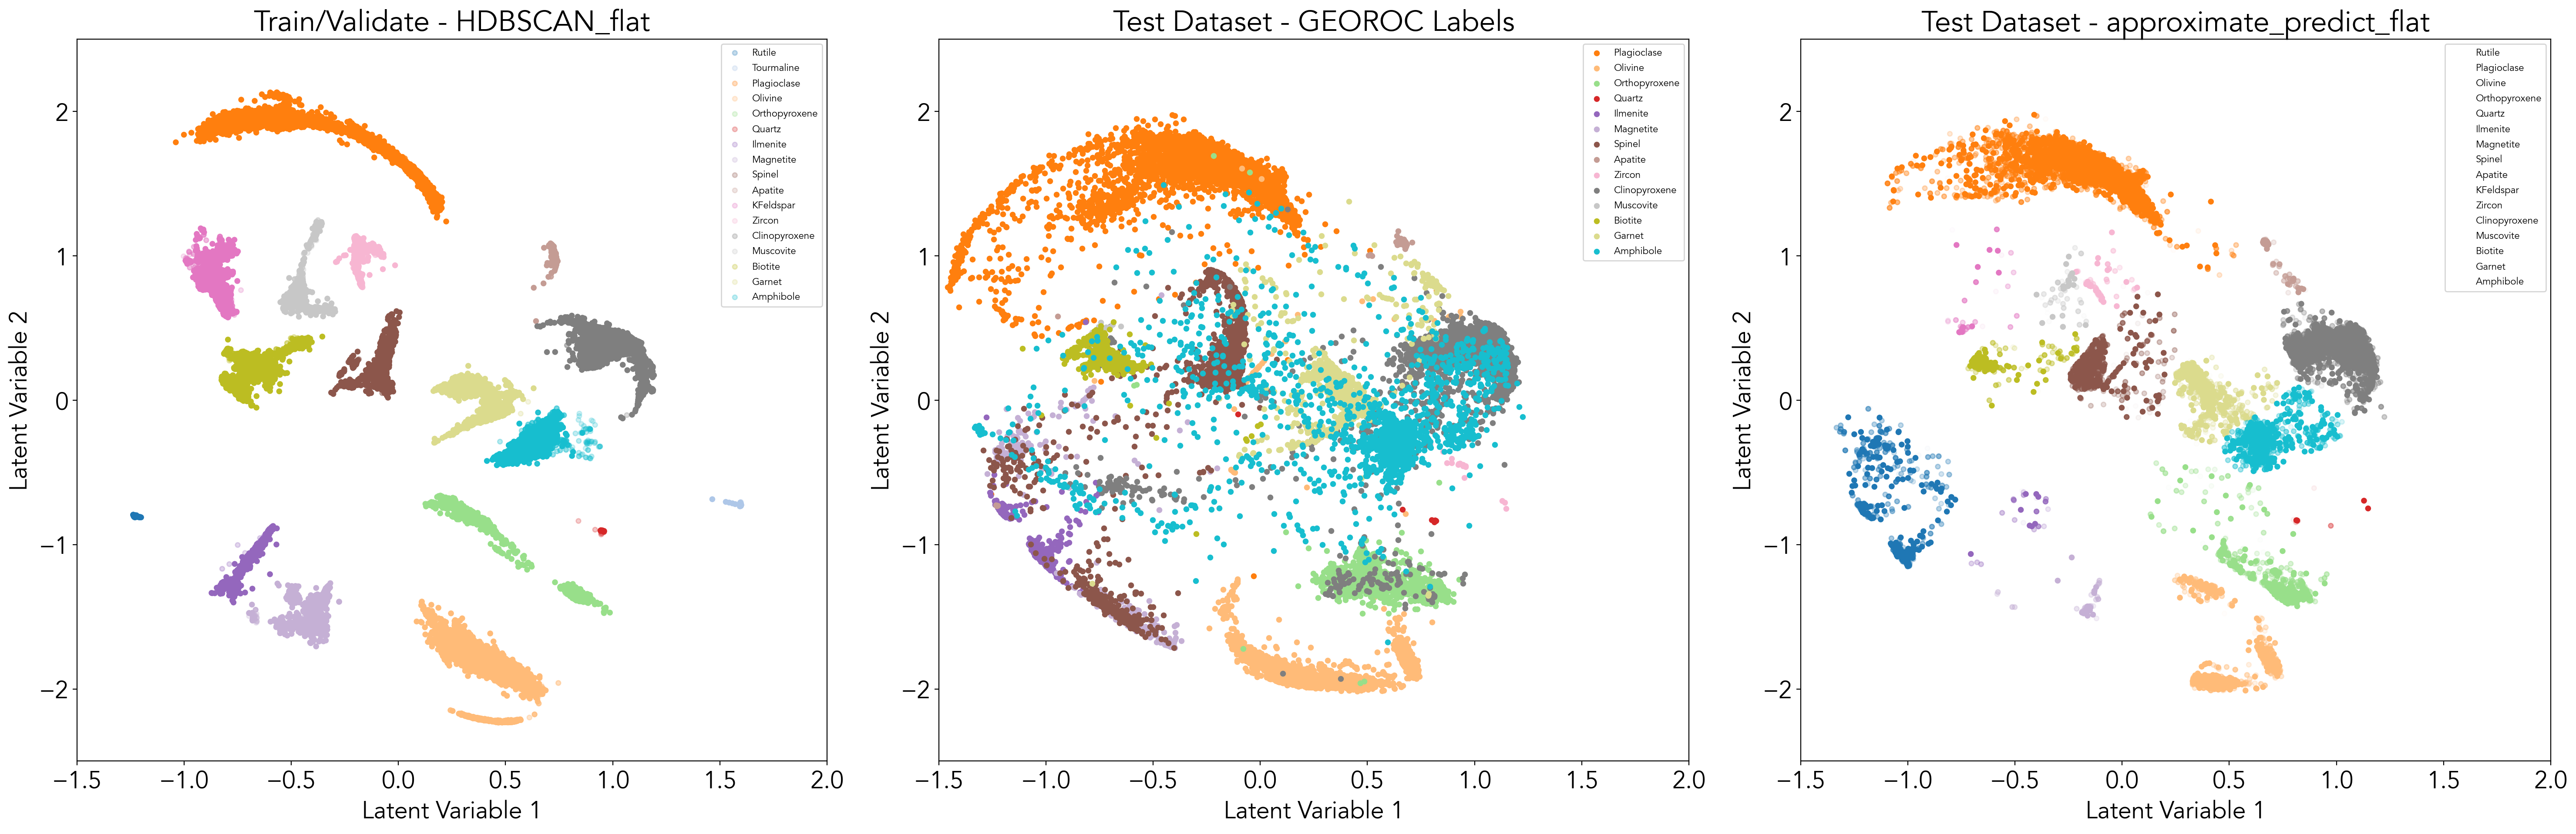

In [8]:
name = 'mindf_256_64_16'
min_df = pd.read_csv('Training_Data/mindf_filt.csv')
z = np.load('autoencoder_parametermatrix/' + name + '_tanh.npz')['z']
z_georoc = getLatent(model, georoc_norm_wt)


train_idx, test_idx = train_test_split(np.arange(len(georoc_df)), test_size=0.05, stratify = georoc_df['Mineral'], random_state=42)
georoc_df_lim = georoc_df.iloc[test_idx]
z_georoc_lim = z_georoc[test_idx]

array, params = feature_normalisation(z, return_params = True)
clusterer = HDBSCAN_flat(array, min_cluster_size=30, cluster_selection_epsilon=0.025, prediction_data=True)
labels, probs = clusterer.labels_, clusterer.probabilities_
array_filt = array[labels!=-1]
labels_filt = labels[labels!=-1]
probs_filt = probs[labels!=-1]
labels[labels==7] = 5 # combine opx
labels[labels==4] = 3 # combine olivine

array_georoc, params_georoc = feature_normalisation(z_georoc_lim, return_params = True)
labels_georoc, probs_georoc = approximate_predict_flat(clusterer, array_georoc, cluster_selection_epsilon=0.025)
array_georoc_filt = array_georoc[labels_georoc!=-1]
labels_georoc_filt = labels_georoc[labels_georoc!=-1]
z_georoc_filt = z_georoc_lim[labels_georoc!=-1]
labels_georoc_filt[labels_georoc_filt==7] = 5
labels_georoc_filt[labels_georoc_filt==4] = 3

tab = plt.get_cmap('tab20')
label_plot = list(set(labels_filt))
label_georoc_plot = list(set(labels_georoc_filt))
cNorm  = mcolors.Normalize(vmin=0, vmax=len(label_plot))
scalarMap = mcm.ScalarMappable(norm=cNorm, cmap=tab)
phase = np.array(['Rutile', 'Tourmaline', 'Plagioclase', 'Olivine', 'Olivine1', 'Orthopyroxene', 'Quartz', 'Orthopyroxene1', 'Ilmenite', 'Magnetite', 'Spinel', 'Apatite', 'KFeldspar', 'Zircon', 'Clinopyroxene', 'Muscovite', 'Biotite', 'Garnet', 'Amphibole'])
label_to_color_idx = {label: idx for idx, label in enumerate(label_plot)}
cluster_to_label = {i: phase[i] for i in label_plot}

fig, ax = plt.subplots(1, 3, figsize = (30, 10))
ax = ax.flatten()

for label in label_plot:
    indx = labels == label
    if np.any(indx):  # Add this condition
        ax[0].scatter(z[indx, 0], z[indx, 1], s=15, color=scalarMap.to_rgba(label_to_color_idx[label]), lw=1, label=cluster_to_label[label])

for i in range(len(phase)):
    indx = georoc_df_lim['Mineral'] == phase[i]
    if np.any(indx):  # Add this condition
        ax[1].scatter(z_georoc_lim[indx, 0], z_georoc_lim[indx, 1], s=15, color=scalarMap.to_rgba(i), lw=1, label=phase[i])

for label in label_georoc_plot:
    indx = labels_georoc_filt == label
    if np.any(indx):  # Add this condition
        ax[2].scatter(z_georoc_filt[indx, 0], z_georoc_filt[indx, 1], s=15, color=scalarMap.to_rgba(label_to_color_idx[label]), lw=1, label=cluster_to_label[label])

ax[0].set_title("Train/Validate - HDBSCAN_flat")
ax[0].set_xlabel("Latent Variable 1")
ax[0].set_ylabel("Latent Variable 2")
ax[0].set_xlim([-1.5, 2.0])
ax[0].set_ylim([-2.5, 2.5])
ax[0].legend(prop={'size': 8})

ax[1].set_title("Test Dataset - GEOROC Labels")
ax[1].set_xlabel("Latent Variable 1")
ax[1].set_ylabel("Latent Variable 2")
ax[1].set_xlim([-1.5, 2.0])
ax[1].set_ylim([-2.5, 2.5])
ax[1].legend(prop={'size': 8})

ax[2].set_title("Test Dataset - approximate_predict_flat")
ax[2].set_xlabel("Latent Variable 1")
ax[2].set_ylabel("Latent Variable 2")
ax[2].set_xlim([-1.5, 2.0])
ax[2].set_ylim([-2.5, 2.5])
ax[2].legend(prop={'size': 8})
plt.tight_layout()
plt.savefig('GEOROC_HDBSCAN_flat.png', bbox_inches='tight', pad_inches = 0.025, dpi=300)

fig, ax = plt.subplots(1, 3, figsize = (30, 10))
ax = ax.flatten()

for label in label_plot:
    indx = labels == label
    if np.any(indx):  # Add this condition
        alphas=probs
        ax[0].scatter(z[indx, 0], z[indx, 1], s=15, color=scalarMap.to_rgba(label_to_color_idx[label]), lw=1, label=cluster_to_label[label], alpha=alphas)

for i in range(len(phase)):
    indx = georoc_df_lim['Mineral'] == phase[i]
    if np.any(indx):  # Add this condition
        ax[1].scatter(z_georoc_lim[indx, 0], z_georoc_lim[indx, 1], s=15, color=scalarMap.to_rgba(i), lw=1, label=phase[i])

for label in label_georoc_plot:
    indx = labels_georoc_filt == label
    if np.any(indx):  # Add this condition
        alphas=probs_georoc
        ax[2].scatter(z_georoc_filt[indx, 0], z_georoc_filt[indx, 1], s=15, color=scalarMap.to_rgba(label_to_color_idx[label]), lw=1, label=cluster_to_label[label], alpha=alphas)

ax[0].set_title("Train/Validate - HDBSCAN_flat")
ax[0].set_xlabel("Latent Variable 1")
ax[0].set_ylabel("Latent Variable 2")
ax[0].set_xlim([-1.5, 2.0])
ax[0].set_ylim([-2.5, 2.5])
ax[0].legend(prop={'size': 8})

ax[1].set_title("Test Dataset - GEOROC Labels")
ax[1].set_xlabel("Latent Variable 1")
ax[1].set_ylabel("Latent Variable 2")
ax[1].set_xlim([-1.5, 2.0])
ax[1].set_ylim([-2.5, 2.5])
ax[1].legend(prop={'size': 8})

ax[2].set_title("Test Dataset - approximate_predict_flat")
ax[2].set_xlabel("Latent Variable 1")
ax[2].set_ylabel("Latent Variable 2")
ax[2].set_xlim([-1.5, 2.0])
ax[2].set_ylim([-2.5, 2.5])
ax[2].legend(prop={'size': 8})
plt.tight_layout()
plt.savefig('GEOROC_HDBSCAN_flat_probs.png', bbox_inches='tight', pad_inches = 0.025, dpi=300)